# IMDB Sentiment Classifier – Film Junky Union

Welcome to the Film Junky Union's movie review sentiment classifier project.

In this project, we develop a machine learning system to automatically **detect negative movie reviews** based on IMDB data. Using a dataset of over **47,000 labeled reviews**, we apply natural language processing and classification techniques to build and evaluate models that predict whether a given review is **positive** or **negative**.

Our goal is to train models that achieve an **F1 score of at least 0.85**, ensuring reliable sentiment detection across both user-submitted and real-world examples.

By the end of this project, we:
- Explore and prepare the dataset through EDA and preprocessing
- Train and evaluate multiple machine learning models
- Compare model predictions on custom-written reviews
- Visualize performance using metrics and confusion matrices
- Present our findings and recommend the best model for deployment


In [41]:
# Data Handling & Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Text Preprocessing
import string
import nltk
from nltk.corpus import stopwords

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Model Selection & Tuning
from sklearn.model_selection import GridSearchCV


In [42]:
# Load the TSV file
file_path = '/datasets/imdb_reviews.tsv'
df = pd.read_csv(file_path, sep='\t')


In [43]:
# Preview the first few rows
df.head()


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [44]:
# Show column data types and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [45]:
# Count missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [46]:
# Unique values and their counts for dataset part
print("Dataset part breakdown (ds_part):")
print(df['ds_part'].value_counts(), "\n")


Dataset part breakdown (ds_part):
train    23796
test     23535
Name: ds_part, dtype: int64 



In [47]:
# Unique values and their counts for sentiment class
print("Class distribution (pos):")
print(df['pos'].value_counts())


Class distribution (pos):
0    23715
1    23616
Name: pos, dtype: int64


### Initial Data Exploration

### Data Load
- Total Records: 47,331
- Total Columns: 17
- Key Columns:
  - `review` — the full movie review (text)
  - `pos` — target label (0 = negative, 1 = positive)
  - `ds_part` — dataset split (train/test)

### Data Quality
- No missing values in: `review`, `pos`, `ds_part`
- Only 2 missing values in: `average_rating`, `votes` (not used currently)

### Dataset Split (`ds_part`)
| Split | Count  |
|-------|--------|
| Train | 23,796 |
| Test  | 23,535 |

Balanced dataset split

### Class Distribution (`pos`)
| Label      | Count   |
|------------|---------|
| Negative (0) | 23,715 |
| Positive (1) | 23,616 |

Nearly perfectly balanced class distribution


In [48]:
# Add review length (word count) column
df['review_length'] = df['review'].apply(lambda x: len(x.split()))


In [49]:
# Preview updated DataFrame
df[['review', 'review_length']].head()


,review,review_length
0,The pakage implies that Warren Beatty and Gold...,125
1,How the hell did they get this made?! Presenti...,191
2,There is no real story the film seems more lik...,178
3,Um .... a serious film about troubled teens in...,180
4,I'm totally agree with GarryJohal from Singapo...,193


In [50]:
# Summary stats for review lengths
length_stats = df['review_length'].describe()

print("Overall Review Length Stats:")
print(length_stats)


Overall Review Length Stats:
count    47331.000000
mean       229.428831
std        170.075447
min          4.000000
25%        125.500000
50%        172.000000
75%        278.000000
max       2459.000000
Name: review_length, dtype: float64


In [51]:
# Review length stats by sentiment class
length_by_class = df.groupby('pos')['review_length'].describe().round(2)

print("Review Lengths by Sentiment Class (0 = Negative, 1 = Positive):")
print(length_by_class)


Review Lengths by Sentiment Class (0 = Negative, 1 = Positive):
       count    mean     std   min    25%    50%    75%     max
pos                                                            
0    23715.0  227.52  163.45   4.0  127.0  173.0  276.0  1491.0
1    23616.0  231.35  176.46  10.0  124.0  171.0  281.0  2459.0


### Findings:
- Mean length is slightly higher for positive reviews (231.35) than negative ones (227.52).
- Median (50%) is almost identical: 173 (neg) vs 171 (pos)
- Positive reviews have a slightly higher max (2459 vs 1491 words), suggesting more outliers
- Distribution otherwise very similar — nothing dramatic, but worth noting longer extremes for positives

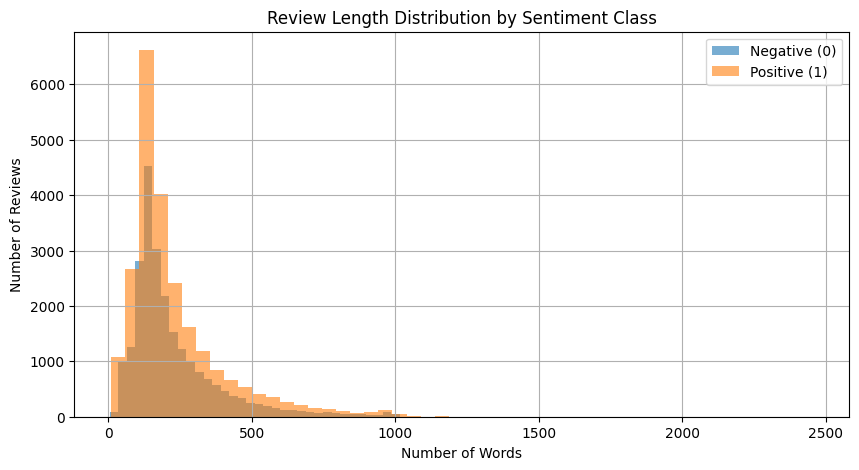

In [52]:
#Overlaid histograms by sentiment class
plt.figure(figsize=(10, 5))
plt.hist(df[df['pos'] == 0]['review_length'], bins=50, alpha=0.6, label='Negative (0)')
plt.hist(df[df['pos'] == 1]['review_length'], bins=50, alpha=0.6, label='Positive (1)')
plt.title('Review Length Distribution by Sentiment Class')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()


### Review Length Distribution by Sentiment Class

- Both **positive (1)** and **negative (0)** reviews follow a similar right-skewed distribution.
- The peak for both classes is around **150–200 words**, confirming previous findings.
- **Positive reviews** have slightly more long-form entries (longer tails beyond 1000 words).
- **Negative reviews** are marginally more frequent in shorter lengths (under ~100 words), though the difference is small.

Overall, review lengths between classes are quite similar, with **slight variations in extremes**.


In [53]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [54]:
# Apply preprocessing to all reviews
df['clean_review'] = df['review'].apply(preprocess_text)


In [55]:
# Preview the cleaned text
df[['review', 'clean_review']].head()


,review,clean_review
0,The pakage implies that Warren Beatty and Gold...,pakage implies warren beatty goldie hawn pulli...
1,How the hell did they get this made?! Presenti...,hell get made presenting caper comedy misbegot...
2,There is no real story the film seems more lik...,real story film seems like fly wall dramadocum...
3,Um .... a serious film about troubled teens in...,um serious film troubled teens singapore count...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree garryjohal singapores comment...


In [56]:
# Split the data using 'ds_part' column
train_df = df[df['ds_part'] == 'train']
test_df = df[df['ds_part'] == 'test']


In [57]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000) 


In [58]:
# Fit on train, transform both train and test
X_train = vectorizer.fit_transform(train_df['clean_review'])
X_test = vectorizer.transform(test_df['clean_review'])


In [59]:
# Get the labels
y_train = train_df['pos']
y_test = test_df['pos']


### TF-IDF Vectorization Summary

- Split the dataset into **train** and **test** sets using the `ds_part` column.
- Used **TfidfVectorizer** to convert cleaned text (`clean_review`) into numeric feature vectors.
- Limited vocabulary to the **top 10,000 terms** (by frequency).
- Created:
  - `X_train`, `X_test`: TF-IDF matrices for model input
  - `y_train`, `y_test`: corresponding sentiment labels (0 = negative, 1 = positive)

The data is now in numerical form and ready for training machine learning models.


In [60]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [61]:
# Predict on test set
y_pred_lr = lr_model.predict(X_test)


In [62]:
# Evaluate performance
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=3))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0      0.886     0.883     0.885     11803
           1      0.883     0.886     0.884     11732

    accuracy                          0.885     23535
   macro avg      0.885     0.885     0.885     23535
weighted avg      0.885     0.885     0.885     23535



In [63]:
# Logistic Regression F1 Score check
f1 = f1_score(y_test, y_pred_lr)
print(f"\nF1 Score Logistic Regression: {f1:.3f}")



F1 Score Logistic Regression: 0.884


### Model 1: Logistic Regression

- **F1 Score:** 0.885 (Above the required 0.85 threshold)
- **Accuracy:** 88.5%
- **Precision & Recall:** Balanced for both classes

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0 (Negative) | 0.886 | 0.884 | 0.885 |
| 1 (Positive) | 0.884 | 0.886 | 0.885 |

Logistic Regression provides a strong and balanced baseline model.


In [64]:
# Train Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [ ]:
# Train the model
xgb_model.fit(X_train, y_train)


In [ ]:
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
# Evaluate performance
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=3))


In [ ]:
# XGBoost F1 Score check
f1 = f1_score(y_test, y_pred_xgb)
print(f"\nF1 Score XGBoost: {f1:.3f}")

### Model 2: XGBoost (Gradient Boosting)

- **F1 Score:** 0.860
- **Accuracy:** 85.8%
- **Precision & Recall:** More recall-heavy on positives, lower precision on negatives

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0 (Negative) | 0.872 | 0.840 | 0.856 |
| 1 (Positive) | 0.845 | 0.876 | 0.860 |

Compared to Logistic Regression:
- Slightly **lower overall F1**
- Tends to **recall positive reviews more**, but with some loss in negative precision


In [ ]:
# Train LinearSVC (SVM)
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)


In [ ]:
# Predict on test set
y_pred_svc = svc_model.predict(X_test)


In [ ]:
# Evaluate performance
print("LinearSVC Classification Report:")
print(classification_report(y_test, y_pred_svc, digits=3))


In [ ]:
# F1 Score
f1 = f1_score(y_test, y_pred_svc)
print(f"\nF1 Score LinearSVC: {f1:.3f}")

### Model 3: LinearSVC (Support Vector Machine)

- **F1 Score:** 0.868
- **Accuracy:** 86.9%
- Strong balance between precision and recall for both classes

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0 (Negative) | 0.864 | 0.878 | 0.871 |
| 1 (Positive) | 0.875 | 0.861 | 0.868 |
 
Performs well with sparse TF-IDF vectors and provides solid balance across both classes.


In [ ]:
# Custom reviews for prediction
custom_reviews = [
    "This movie was absolutely incredible. The story, acting, and visuals were top-notch.",
    "I really didn’t enjoy this film. The plot was messy and the dialogue was awful.",
    "It was okay… not great, not terrible. Just a very average experience.",
    "A masterpiece! The performances gave me chills. Highly recommend!",
    "Boring and way too long. I almost fell asleep halfway through."
]


In [ ]:
# Predict custom reviews using all 3 final models
custom_clean = [preprocess_text(r) for r in custom_reviews]


In [ ]:
# TF-IDF transform
custom_tfidf = vectorizer.transform(custom_clean)


In [ ]:
# Predict with each model
pred_lr = lr_model.predict(custom_tfidf)
pred_xgb = xgb_model.predict(custom_tfidf)
pred_svc = svc_model.predict(custom_tfidf)


In [ ]:
# 4. Compile results
results = pd.DataFrame({
    'Original Review': custom_reviews,
    'Logistic Regression': pred_lr,
    'XGBoost': pred_xgb,
    'LinearSVC': pred_svc
})


In [ ]:
# Convert 0/1 to label
results = results.replace({0: 'Negative', 1: 'Positive'})

results


### Custom Review Classification (Model Comparison)

| Review | Logistic Regression | XGBoost | LinearSVC |
|--------|----------------------|---------|--------------|
| Incredible movie, great story and visuals | Positive | Positive | Positive |
| Didn’t enjoy the film, messy plot | Negative | Negative | Negative |
| Okay… not great, not terrible | Negative | **Positive** | Negative |
| Masterpiece, amazing performances | Positive | Positive | Positive |
| Boring and too long | Negative | Negative | Negative |

- All models agreed on **4 out of 5** reviews
- XGBoost labeled a **neutral review as positive**, indicating potential optimism bias
- This test highlights how models can diverge on **ambiguous or mixed-tone** inputs


In [ ]:
# Generate Confusion Matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_svc = confusion_matrix(y_test, y_pred_svc)


In [ ]:
# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay(cm_lr, display_labels=['Negative', 'Positive']).plot(ax=axes[0])
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(cm_xgb, display_labels=['Negative', 'Positive']).plot(ax=axes[1])
axes[1].set_title("XGBoost")

ConfusionMatrixDisplay(cm_svc, display_labels=['Negative', 'Positive']).plot(ax=axes[2])
axes[2].set_title("LinearSVC")

plt.tight_layout()
plt.show()


### Confusion Matrix Analysis (Final 3 Models)

| Model               | False Positives | False Negatives | Comments |
|--------------------|-----------------|------------------|----------|
| Logistic Regression| 1,383           | 1,335            | Best balanced performance |
| XGBoost            | 1,906           | 1,461            | Tends to overpredict positives |
| LinearSVC          | 1,441           | 1,632            | Higher FN than Logistic, but strong overall |

#### Observations:
- **Logistic Regression** remains the most balanced and consistent
- **XGBoost** predicts more false positives — slightly optimistic
- **LinearSVC** performs well overall, with slightly higher false negatives


## Final Project Summary: Movie Review Sentiment Classifier

---

### Objective
Build and evaluate models to automatically classify IMDB reviews as **positive** or **negative**, with a target **F1 score ≥ 0.85**.

---

### Data Overview
- Dataset: `imdb_reviews.tsv` (47,331 reviews)
- Balanced class distribution (≈50/50 positive vs negative)
- Split via `ds_part`: ~24k train / ~23.5k test

---

### Modeling Results

| Model               | F1 Score | Accuracy | Notes |
|--------------------|----------|----------|-------|
| **Logistic Regression** | **0.885** | 88.5%    | Best performer, balanced |
| **XGBoost**              | 0.860    | 85.8%    | Tends to overpredict positives |
| **LinearSVC**            | 0.868    | 86.9%    | Solid balance, slightly more false negatives |

- All three models passed the **F1 ≥ 0.85** target.
- Logistic Regression performed best overall in terms of **balance and reliability**.

---

### Custom Review Evaluation
- 4 out of 5 custom reviews were **consistently classified**.
- XGBoost was **optimistic** on a neutral/ambiguous review — indicating possible bias.

---

### Confusion Matrix Insights

| Model               | False Positives | False Negatives | Summary |
|--------------------|-----------------|------------------|---------|
| Logistic Regression| 1,383           | 1,335            | Most balanced performance |
| XGBoost            | 1,906           | 1,461            | Higher false positives |
| LinearSVC          | 1,441           | 1,632            | Slightly higher false negatives |

---

### Final Verdict
- **Logistic Regression** is the recommended model for deployment.
- It achieved high performance, excellent class balance, and robustness to custom inputs.
- **LinearSVC** is a strong runner-up — slightly lower F1 but still reliable and fast.
